1. See varias `generate_g*` functions in [`generate_g.jl`](generate_g.jl) and  [`generate_g.c`](generate_g.c). All functions except Julia `generate_g` only fill the matrix without allocating it in order not to benchmarking Linux memory management...

2. See [below](#Benchmark-results) for the benchmark results on two computers

    The results are generated with the [`time_generate.jl`](time_generate.jl) script.

3. See [below](#Error)

    The problem is not stable because the bottom right element of the `U` matrix
    is $\dfrac{(n + 1)n}{2}$ while all other diagonal terms are $0$, resulting in a
    very large condition number when $n$ is large

In [55]:
include("generate_g.jl")

generate_g (generic function with 1 method)

In [1]:
using JSON

In [3]:
using PyPlot

In [2]:
perf_6700k = JSON.parsefile("./i7-6700k.json");
perf_4702hq = JSON.parsefile("./i7-4702hq.json");

In [4]:
function extract_data(input)
    data = Dict{UTF8String,NTuple{3,Vector{Float64}}}()
    for p in input
        n::Int = p["n"]
        for k in keys(p)
            k == "n" && continue
            avg::Float64, std::Float64 = p[k]
            if !(k in keys(data))
                data[k] = ([Float64(n)], [avg], [std])
            else
                ary = data[k]
                push!(ary[1], n)
                push!(ary[2], avg)
                push!(ary[3], std)
            end
        end
    end
    data
end

extract_data (generic function with 1 method)

In [6]:
data_4702hq = extract_data(perf_4702hq);
data_6700k = extract_data(perf_6700k);

In [35]:
marks = [("alloc", "ro-"),
    ("gen_cilk", "co-"),
    ("fill_cilk", "c-"),
    ("gen_omp", "yo-"),
    ("fill_omp", "y-"),
    ("gen_c", "go-"),
    ("gen", "bo-"),
    ("fill", "b-"),
    ("memset", "m-")];

In [27]:
ns = 1:10000
mem_max_4702hq = ns.^2 * 8 / 25.6e9;
mem_max_6700k = ns.^2 * 8 / 34.1e9;

#### Benchmark results

* The range of $n$ is extended to $1 ... 10000$ since matrixes smaller than $1000\times1000$ (of `double`) fits in the L3 cache.

* The plots below shows the timing for various different methods

    The `gen_*` functions generates the matrix while the `fill_*` functions fill the
    matrix with zeros. Only `alloc`, allocate a matrix at each iteration. All the
    `fill_*` implemented in C ends up calling `memset` (due to GCC optimization).

    1. `gen` / `fill`

        Generator and fill implemented in Julia

    2. `gen_cilk` / `fill_cilk`

        Parallelized with `cilk_for`

    3. `gen_omp` / `fill_omp`

        Parallelized with `#pragma omp parallel for`

    The thick red dashed line is the limit given by the maximum memory bandwidth of
    the CPU and the thick green dashed line is half of the memory bandwidth,
    corresponding to the maximum performance with write back memory.

    The vertical red line is the size of the L3 cache and the green line is the size
    of the L2 cache.

    For sizes no greater than `1000`, many benchmarks shows performance much better
    than what's allowed by the memory bandwidth (which confused me for a long
    time.......). However, when the array is bigger than the L3 cache size, the
    performance are very closed to what one would expect from the memory bandwidth.

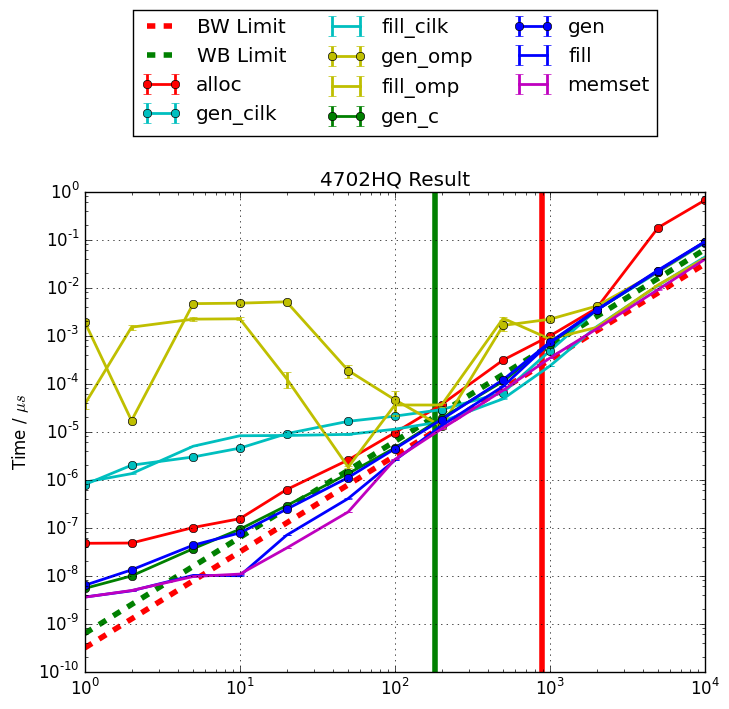

In [53]:
figure()

gca()[:set_xscale]("log", nonposx="clip")
gca()[:set_yscale]("log", nonposy="clip")

plot(ns, mem_max_4702hq, "r", linewidth=4, label="BW Limit", linestyle="--")
plot(ns, mem_max_4702hq * 2, "g", linewidth=4, label="WB Limit", linestyle="--")
axvline(x=sqrt(6144 * 1024 / 8), color="r", linewidth=4)
axvline(x=sqrt(256 * 1024 / 8), color="g", linewidth=4)

for (t, fmt) in marks
    v = data_4702hq[t]
    errorbar(v[1], v[2], v[3], fmt=fmt, label=t, linewidth=2)
end

ylabel("Time / \$\\mu s\$")

legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.4))
title("4702HQ Result")
grid()

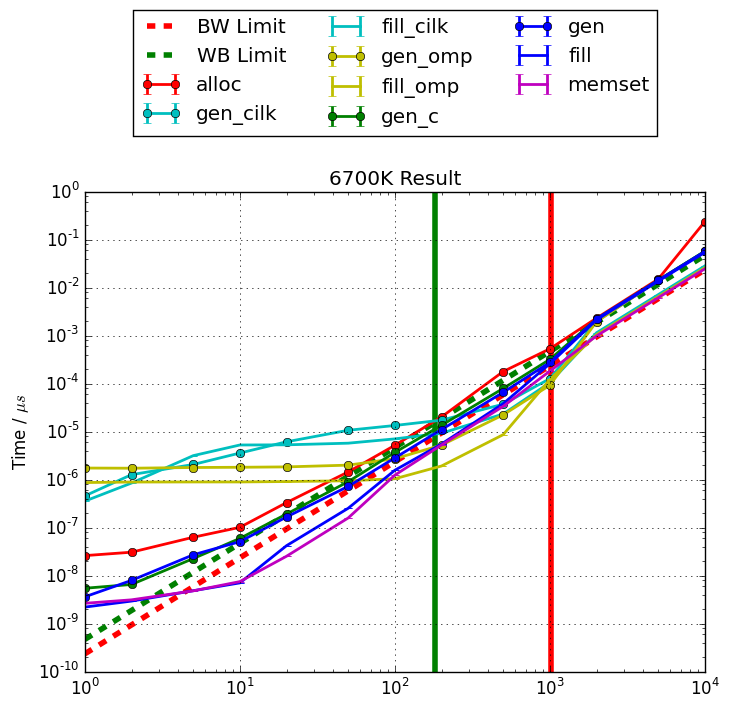

In [54]:
figure()

gca()[:set_xscale]("log", nonposx="clip")
gca()[:set_yscale]("log", nonposy="clip")

plot(ns, mem_max_6700k, "r", linewidth=4, label="BW Limit", linestyle="--")
plot(ns, mem_max_6700k * 2, "g", linewidth=4, label="WB Limit", linestyle="--")
axvline(x=sqrt(8192 * 1024 / 8), color="r", linewidth=4)
axvline(x=sqrt(256 * 1024 / 8), color="g", linewidth=4)

for (t, fmt) in marks
    v = data_6700k[t]
    errorbar(v[1], v[2], v[3], fmt=fmt, label=t, linewidth=2)
end

ylabel("Time / \$\\mu s\$")

legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.4))
title("6700K Result")
grid()

In [56]:
function calc_error(n)
    G = generate_g(n)
    b = G * ones(n)
    norm(G \ b - 1)
end

calc_error (generic function with 1 method)

In [59]:
ns = 1:200
es = [calc_error(n) for n in 1:200];

#### Error

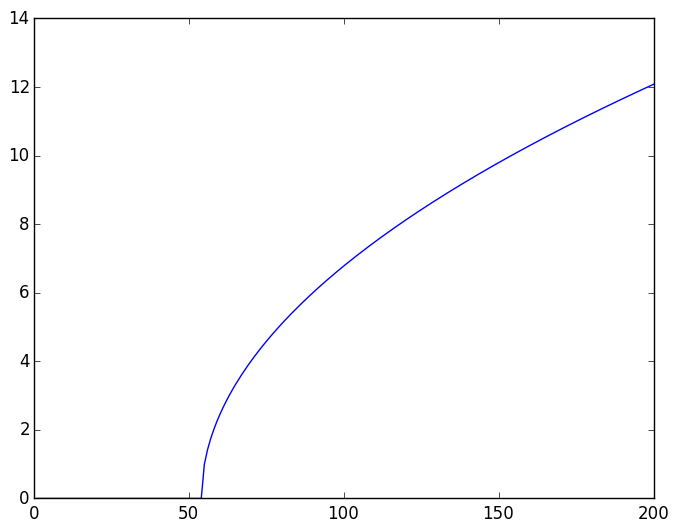

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe599b14780>

In [58]:
plot(ns, es)